In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:

file_path = 'C:/Users/thoma/Downloads/imerg_pr_201911_3h.nc4'
dataset = nc.Dataset(file_path)

# Afficher les informations sur le fichier
#print(dataset)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/cdi)
    history: Mon Sep 27 17:58:00 2021: cdo --timestat_date first -L -f nc4c -z zip_6 -k grid -b F32 -setunit,mm/3h -timselsum,6 -mulc,0.5 -setmisstonn /home/archive/OBSERVATIONS/IMERG/30m/precipitationCal/ll/nc4/2019/11/imerg_precipitationCal_ll_201911_30m.nc4 /HOME/roberge/Work/snow3/OBSERVATIONS/IMERG/IMERG_3h_timestatdate/imerg_201911/imerg_pr_201911_3h.nc4
    Conventions: CF-1.6
    FileHeader: DOI=10.5067/GPM/IMERG/3B-HH/06;
DOIauthority=http://dx.doi.org/;
DOIshortName=3IMERGHH;
AlgorithmID=3IMERGHH;
AlgorithmVersion=3IMERGH_6.3;
FileName=3B-HHR.MS.MRG.3IMERG.20191101-S000000-E002959.0000.V06B.HDF5;
SatelliteName=MULTI;
InstrumentName=MERGED;
GenerationDateTime=2020-02-27T08:31:00.000Z;
StartGranuleDateTime=2019-11-01T00:00:00.000Z;
StopGranuleDateTime=2019-11-01T00:29:59.999Z;
GranuleNumber=;
NumberOfSwaths=0;
Num

In [4]:
# Examiner les dimensions
#print(f"Dimensions: {dataset.dimensions.keys()}")

# Examiner les variables
#print(f"Variables: {dataset.variables.keys()}")

# Aperçu rapide des variables
#for var in dataset.variables.keys():
   # print(f"{var}: {dataset.variables[var]}")


Dimensions: dict_keys(['time', 'bnds', 'lon', 'lat'])
Variables: dict_keys(['time', 'time_bnds', 'lon', 'lat', 'precipitationCal'])
time: <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    bounds: time_bnds
    units: seconds since 1970-01-01 00:00:00 UTC
    calendar: standard
    axis: T
unlimited dimensions: time
current shape = (240,)
filling on, default _FillValue of 9.969209968386869e+36 used
time_bnds: <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (240, 2)
filling on, default _FillValue of 9.969209968386869e+36 used
lon: <class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (3600,)
filling on, default _FillValue of 9.969209968386869e+36 used
lat: <class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    standard_name: latitude
    long_name: latitude
    units:

In [6]:
# Extraire la variable de précipitation
precipitation = dataset.variables['precipitationCal'][:]

# Extraire les coordonnées de latitude et de longitude
latitudes = dataset.variables['lat'][:]
longitudes = dataset.variables['lon'][:]
times = dataset.variables['time'][:]


Précipitation shape: (240, 1800, 3600)


In [7]:
# analyse des séries temporelles

#1 et 2: 


# Coordonnées des emplacements
locations = {
    'Kuala Lumpur': {'lat': 3.1, 'lon': 101.6},
    'Montréal': {'lat': 45.5, 'lon': -73.5},
    'Point océanique': {'lat': 5.0, 'lon': 106.0},
    'Lieu au choix': {'lat': 45.65, 'lon': 0.16}  # Angoulême
}

# Fonction pour trouver les indices de grille les plus proches
def find_nearest_grid_point(lat_array, lon_array, lat, lon):
    lat_idx = np.abs(lat_array - lat).argmin()
    lon_idx = np.abs(lon_array - lon).argmin()
    return lat_idx, lon_idx

# Trouver les indices de grille les plus proches pour chaque emplacement
grid_points = {}
latitudes = dataset.variables['lat'][:]
longitudes = dataset.variables['lon'][:]

for location, coords in locations.items():
    lat_idx, lon_idx = find_nearest_grid_point(latitudes, longitudes, coords['lat'], coords['lon'])
    grid_points[location] = {'lat_idx': lat_idx, 'lon_idx': lon_idx}
    print(f"{location}: Grid point lat index = {lat_idx}, lon index = {lon_idx}")


Kuala Lumpur: Grid point lat index = 930, lon index = 2815
Montréal: Grid point lat index = 1354, lon index = 1064
Point océanique: Grid point lat index = 949, lon index = 2859
Lieu au choix: Grid point lat index = 1356, lon index = 1801


C:\Users\thoma\AppData\Local\Temp\ipykernel_233220\2050359601.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuster la marge supérieure pour ne pas écraser le titre


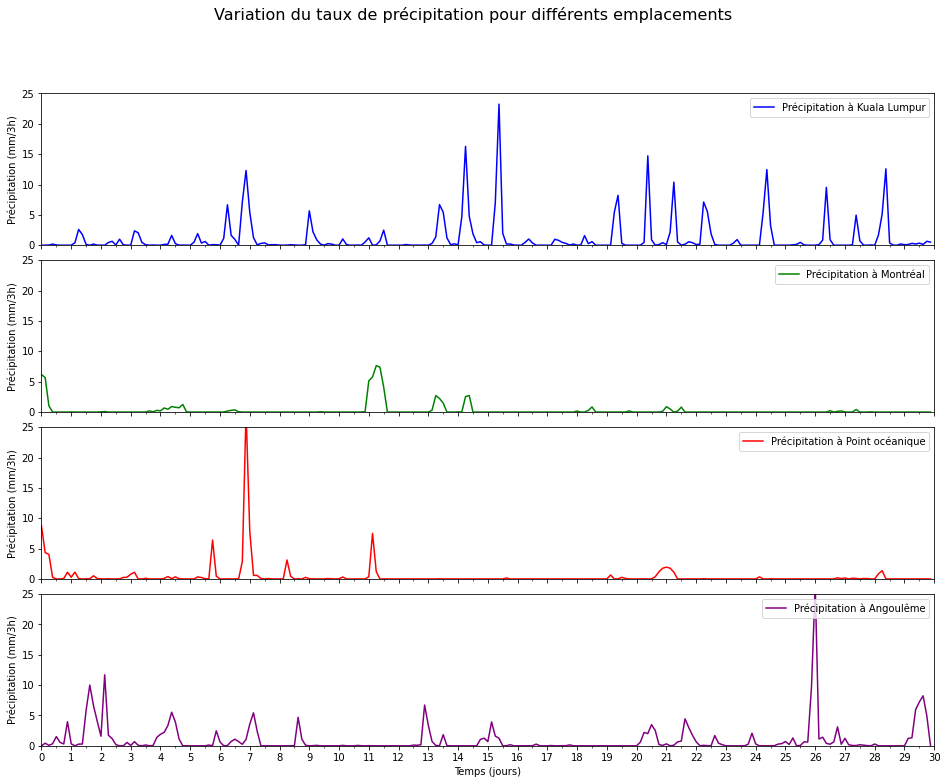

In [8]:


# Palette de couleurs pour chaque emplacement
colors = ['blue', 'green', 'red', 'purple']

fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True, gridspec_kw={'hspace': 0.1})  # Légère augmentation de l'espace vertical (hspace=0.1)

# Limites uniformes pour l'axe y et l'axe x (précipitation et jours)
y_limits = [0, 25]  # Ajustez les limites selon les besoins
x_limits = [0, 30]  # 30 jours

# Extraire et tracer les données de précipitation pour chaque emplacement
for i, (location, point) in enumerate(grid_points.items()):
    lat_idx, lon_idx = point['lat_idx'], point['lon_idx']
    
    precipitation = dataset.variables['precipitationCal'][:, lat_idx, lon_idx]
    
    days = np.arange(len(precipitation)) / 8
    
    axes[i].plot(days, precipitation, label=f'Précipitation à {location}', color=colors[i])
    axes[i].set_ylabel("Précipitation (mm/3h)")
    axes[i].set_xlim(x_limits)
    axes[i].set_ylim(y_limits)
    axes[i].legend(loc='upper right')

axes[-1].legend(["Précipitation à Angoulême"], loc='upper right')

axes[-1].xaxis.set_major_locator(plt.MultipleLocator(1))
axes[-1].xaxis.set_minor_locator(plt.MultipleLocator(0.5))

fig.suptitle("Variation du taux de précipitation pour différents emplacements", fontsize=16)

plt.subplots_adjust(hspace=0.1)  # Réduire légèrement l'espacement

axes[-1].set_xlabel("Temps (jours)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 

# Sauvegarder la figure dans le répertoire 'C:\Users\thoma\OneDrive\Images\Saved Pictures'
#save_path = r'C:\Users\thoma\OneDrive\Images\Saved Pictures\EXP1_A)2.png'
#plt.savefig(save_path, bbox_inches='tight')
plt.show()


In [9]:
# 3.a)  Calculer l'accumulation totale de précipitation pour chaque emplacement
for location, point in grid_points.items():
    lat_idx, lon_idx = point['lat_idx'], point['lon_idx']
    
    # Extraire la série temporelle de précipitation
    precipitation = dataset.variables['precipitationCal'][:, lat_idx, lon_idx]
    
    # Filtrer les valeurs manquantes (-9999.9 est la valeur manquante)
    precipitation = np.where(precipitation == -9999.9, np.nan, precipitation)
    
    # Accumulation totale de précipitation
    total_precipitation = np.nansum(precipitation)
    print(f"Total précipitation à {location}: {total_precipitation} mm")


Total précipitation à Kuala Lumpur: 277.0807189941406 mm
Total précipitation à Montréal: 66.72679138183594 mm
Total précipitation à Point océanique: 97.29389190673828 mm
Total précipitation à Lieu au choix: 226.6837921142578 mm


In [10]:
# 3.b) Calculer le nombre de mesures avec un taux de précipitation > 0 mm/3h et la fréquence de précipitation
for location, point in grid_points.items():
    lat_idx, lon_idx = point['lat_idx'], point['lon_idx']
    
    # Extraire la série temporelle de précipitation
    precipitation = dataset.variables['precipitationCal'][:, lat_idx, lon_idx]
    
    # Filtrer les valeurs manquantes (-9999.9 est la valeur manquante)
    precipitation = np.where(precipitation == -9999.9, np.nan, precipitation)
    
    # Mesures avec précipitation > 0 mm/3h
    precip_above_zero = precipitation[precipitation > 0]
    
    # Nombre de mesures avec précipitation > 0
    num_rainy_periods = len(precip_above_zero)
    
    # Fraction du temps qu'il pleut (nombre de périodes pluvieuses / total de périodes)
    fraction_rainy = num_rainy_periods / len(precipitation)
    
    print(f"Nombre de mesures avec précipitation > 0 mm à {location}: {num_rainy_periods}")
    print(f"Fréquence de précipitation à {location}: {fraction_rainy * 100:.2f}%")


Nombre de mesures avec précipitation > 0 mm à Kuala Lumpur: 167
Fréquence de précipitation à Kuala Lumpur: 69.58%
Nombre de mesures avec précipitation > 0 mm à Montréal: 69
Fréquence de précipitation à Montréal: 28.75%
Nombre de mesures avec précipitation > 0 mm à Point océanique: 90
Fréquence de précipitation à Point océanique: 37.50%
Nombre de mesures avec précipitation > 0 mm à Lieu au choix: 138
Fréquence de précipitation à Lieu au choix: 57.50%


In [11]:
# 3.C) Calculer la précipitation moyenne et l'intensité de précipitation moyenne
for location, point in grid_points.items():
    lat_idx, lon_idx = point['lat_idx'], point['lon_idx']
    
    # Extraire la série temporelle de précipitation
    precipitation = dataset.variables['precipitationCal'][:, lat_idx, lon_idx]
    
    # Filtrer les valeurs manquantes (-9999.9 est la valeur manquante)
    precipitation = np.where(precipitation == -9999.9, np.nan, precipitation)
    
    # Précipitation moyenne (toutes les mesures)
    mean_precipitation = np.nanmean(precipitation)
    
    # Intensité de précipitation moyenne (mesures avec précipitation > 0)
    precip_above_zero = precipitation[precipitation > 0]
    mean_intensity = np.nanmean(precip_above_zero)
    
    print(f"Précipitation moyenne à {location}: {mean_precipitation} mm")
    print(f"Intensité moyenne de précipitation à {location}: {mean_intensity} mm")


Précipitation moyenne à Kuala Lumpur: 1.1545029878616333 mm
Intensité moyenne de précipitation à Kuala Lumpur: 1.6591657400131226 mm
Précipitation moyenne à Montréal: 0.27802830934524536 mm
Intensité moyenne de précipitation à Montréal: 0.9670549631118774 mm
Précipitation moyenne à Point océanique: 0.40539121627807617 mm
Intensité moyenne de précipitation à Point océanique: 1.0810432434082031 mm
Précipitation moyenne à Lieu au choix: 0.9445158243179321 mm
Intensité moyenne de précipitation à Lieu au choix: 1.6426361799240112 mm


In [12]:
# 3.D) Calculer la durée maximale des événements de précipitation
for location, point in grid_points.items():
    lat_idx, lon_idx = point['lat_idx'], point['lon_idx']
    
    # Extraire la série temporelle de précipitation
    precipitation = dataset.variables['precipitationCal'][:, lat_idx, lon_idx]
    
    # Filtrer les valeurs manquantes (-9999.9 est la valeur manquante)
    precipitation = np.where(precipitation == -9999.9, np.nan, precipitation)
    
    # Identifier les événements de précipitation (précipitation > 0)
    is_raining = precipitation > 0
    max_event_duration = 0
    current_event_duration = 0
    
    for raining in is_raining:
        if raining:
            current_event_duration += 1
        else:
            max_event_duration = max(max_event_duration, current_event_duration)
            current_event_duration = 0
    
    # Si la dernière séquence est un événement, la comparer avec la durée maximale
    max_event_duration = max(max_event_duration, current_event_duration)
    
    # Convertir en heures (chaque étape correspond à 3 heures)
    max_event_duration_hours = max_event_duration * 3
    print(f"Durée maximale des événements de précipitation à {location}: {max_event_duration_hours} heures")


Durée maximale des événements de précipitation à Kuala Lumpur: 45 heures
Durée maximale des événements de précipitation à Montréal: 36 heures
Durée maximale des événements de précipitation à Point océanique: 27 heures
Durée maximale des événements de précipitation à Lieu au choix: 78 heures


In [13]:
#3.E)  Calculer la valeur maximale du taux de précipitation
for location, point in grid_points.items():
    lat_idx, lon_idx = point['lat_idx'], point['lon_idx']
    
    # Extraire la série temporelle de précipitation
    precipitation = dataset.variables['precipitationCal'][:, lat_idx, lon_idx]
    
    # Filtrer les valeurs manquantes (-9999.9 est la valeur manquante)
    precipitation = np.where(precipitation == -9999.9, np.nan, precipitation)
    
    # Calculer la valeur maximale du taux de précipitation
    max_precipitation = np.nanmax(precipitation)
    
    print(f"Valeur maximale du taux de précipitation à {location}: {max_precipitation} mm/3h")


Valeur maximale du taux de précipitation à Kuala Lumpur: 23.24861717224121 mm/3h
Valeur maximale du taux de précipitation à Montréal: 7.6547369956970215 mm/3h
Valeur maximale du taux de précipitation à Point océanique: 27.615812301635742 mm/3h
Valeur maximale du taux de précipitation à Lieu au choix: 26.44626808166504 mm/3h


In [14]:

# 3.F) Fonction pour calculer la corrélation temporelle avec les points voisins
def calculate_correlation(location, lat_idx, lon_idx):
    # Extraire la série temporelle de précipitation pour l'emplacement original
    original_precipitation = dataset.variables['precipitationCal'][:, lat_idx, lon_idx]
    original_precipitation = np.where(original_precipitation == -9999.9, np.nan, original_precipitation)
    
    # Définir les décalages pour les voisins (Nord, Sud, Est, Ouest)
    neighbors = {
        'Nord': (lat_idx + 5, lon_idx),
        'Sud': (lat_idx - 5, lon_idx),
        'Est': (lat_idx, lon_idx + 5),
        'Ouest': (lat_idx, lon_idx - 5)
    }
    
    correlations = {}
    
    for direction, (n_lat_idx, n_lon_idx) in neighbors.items():
        if 0 <= n_lat_idx < len(latitudes) and 0 <= n_lon_idx < len(longitudes):
            # Extraire la série temporelle du voisin
            neighbor_precipitation = dataset.variables['precipitationCal'][:, n_lat_idx, n_lon_idx]
            neighbor_precipitation = np.where(neighbor_precipitation == -9999.9, np.nan, neighbor_precipitation)
            
            # Calculer la corrélation de Pearson entre les deux séries temporelles
            correlation, _ = stats.pearsonr(original_precipitation, neighbor_precipitation)
            correlations[direction] = correlation
    
    return correlations

# Calculer les corrélations pour chaque emplacement
for location, point in grid_points.items():
    lat_idx, lon_idx = point['lat_idx'], point['lon_idx']
    
    # Calculer la corrélation pour les 4 points voisins
    correlations = calculate_correlation(location, lat_idx, lon_idx)
    
    # Afficher les résultats
    print(f"Corrélations temporelles à {location}: {correlations}")


Corrélations temporelles à Kuala Lumpur: {'Nord': 0.5424545567280732, 'Sud': 0.30628337411262263, 'Est': 0.24594539685209266, 'Ouest': 0.10594952705768225}
Corrélations temporelles à Montréal: {'Nord': 0.7687765379199463, 'Sud': 0.7329240586215251, 'Est': 0.8923279601994591, 'Ouest': 0.2766474196035539}
Corrélations temporelles à Point océanique: {'Nord': 0.28397885237911535, 'Sud': 0.8647696417890692, 'Est': 0.7897408119633241, 'Ouest': 0.8323200749843049}
Corrélations temporelles à Lieu au choix: {'Nord': 0.729541096210967, 'Sud': 0.4850769075981254, 'Est': 0.7023473300566639, 'Ouest': 0.6772006707771514}


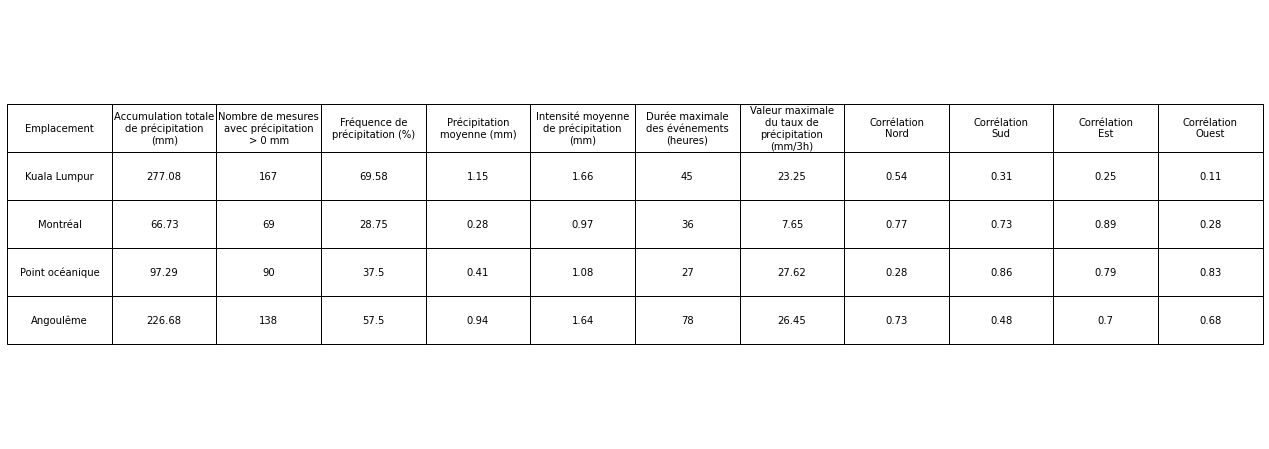

In [20]:

# Données du tableau avec retour à la ligne explicite dans les titres de colonnes
data = {
    'Emplacement': ['Kuala Lumpur', 'Montréal', 'Point océanique', 'Angoulême'],
    'Accumulation totale\nde précipitation\n(mm)': [277.08, 66.73, 97.29, 226.68],
    'Nombre de mesures\navec précipitation\n> 0 mm': [167, 69, 90, 138],
    'Fréquence de\nprécipitation (%)': [69.58, 28.75, 37.50, 57.50],
    'Précipitation\nmoyenne (mm)': [1.15, 0.28, 0.41, 0.94],
    'Intensité moyenne\nde précipitation\n(mm)': [1.66, 0.97, 1.08, 1.64],
    'Durée maximale\ndes événements\n(heures)': [45, 36, 27, 78],
    'Valeur maximale\ndu taux de\nprécipitation\n(mm/3h)': [23.25, 7.65, 27.62, 26.45],
    'Corrélation\nNord': [0.54, 0.77, 0.28, 0.73],
    'Corrélation\nSud': [0.31, 0.73, 0.86, 0.48],
    'Corrélation\nEst': [0.25, 0.89, 0.79, 0.70],
    'Corrélation\nOuest': [0.11, 0.28, 0.83, 0.68]
}

# Créer un DataFrame
df = pd.DataFrame(data)

# Configurer la figure pour un grand tableau
fig, ax = plt.subplots(figsize=(15, 8))  # Augmenter la taille de la figure pour plus d'espacement
ax.axis('tight')
ax.axis('off')

# Créer le tableau avec les sauts de ligne dans les cases
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

# Appliquer du style au tableau
table.auto_set_font_size(False)
table.set_fontsize(10)

# Ajuster la taille des cellules pour permettre d'afficher plusieurs lignes
table.scale(1.5, 4)  # Augmenter la mise à l'échelle des cellules pour agrandir les cases

# Sauvegarder l'image
plt.savefig('C:/Users/thoma/OneDrive/Images/Saved Pictures/tableau.png', bbox_inches='tight', dpi=200)

# Afficher le tableau
plt.show()


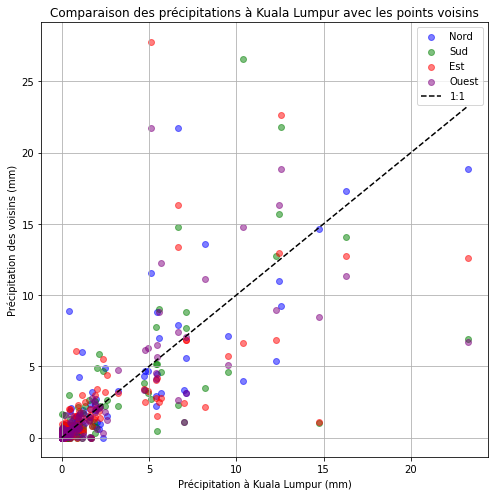

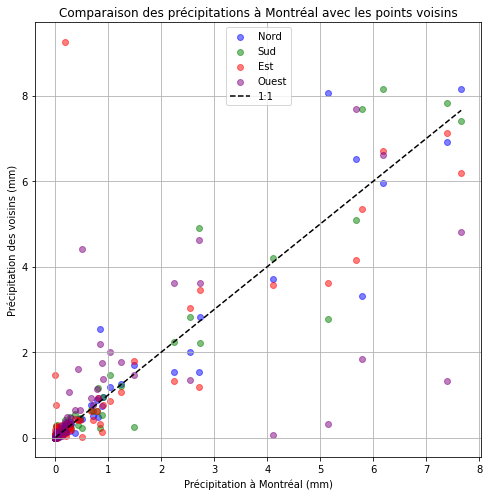

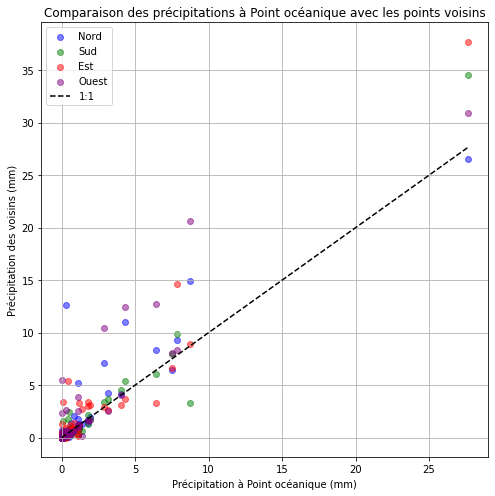

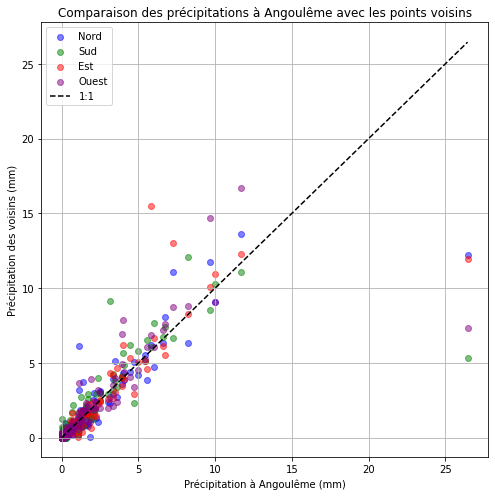

In [21]:


# Couleurs pour chaque direction
colors = {'Nord': 'blue', 'Sud': 'green', 'Est': 'red', 'Ouest': 'purple'}

# Fonction pour créer un seul scatter plot avec les 4 voisins
def plot_scatter(location, lat_idx, lon_idx):
    # Extraire la série temporelle de précipitation pour l'emplacement original
    original_precipitation = dataset.variables['precipitationCal'][:, lat_idx, lon_idx]
    original_precipitation = np.where(original_precipitation == -9999.9, np.nan, original_precipitation)
    
   
    
    # Définir les décalages plus petits pour les voisins (Nord, Sud, Est, Ouest)
    neighbors = {
        'Nord': (lat_idx + 1, lon_idx),
        'Sud': (lat_idx - 1, lon_idx),
        'Est': (lat_idx, lon_idx + 1),
        'Ouest': (lat_idx, lon_idx - 1)
    }
    
    plt.figure(figsize=(8, 8))
    
    # Tracer les scatter plots pour chaque direction avec des couleurs différentes
    for direction, (n_lat_idx, n_lon_idx) in neighbors.items():
        if 0 <= n_lat_idx < len(dataset.variables['lat']) and 0 <= n_lon_idx < len(dataset.variables['lon']):
            # Extraire la série temporelle du voisin
            neighbor_precipitation = dataset.variables['precipitationCal'][:, n_lat_idx, n_lon_idx]
            neighbor_precipitation = np.where(neighbor_precipitation == -9999.9, np.nan, neighbor_precipitation)
            
    
            
            # Si les données du voisin ne sont pas toutes NaN, tracer le scatter plot
            if not np.all(np.isnan(neighbor_precipitation)):
                plt.scatter(original_precipitation, neighbor_precipitation, alpha=0.5, label=direction, color=colors[direction])
    
    # Ajouter la ligne 1:1 (relation idéale)
    plt.plot([0, np.nanmax(original_precipitation)], [0, np.nanmax(original_precipitation)], 'k--', label='1:1')
    
    # Configurer le graphique
    plt.title(f"Comparaison des précipitations à {location} avec les points voisins")
    plt.xlabel(f"Précipitation à {location} (mm)")
    plt.ylabel("Précipitation des voisins (mm)")
    plt.legend()
    plt.grid(True)
    
    # Sauvegarder la figure dans un fichier PNG
    save_path = f"C:/Users/thoma/OneDrive/Images/Saved Pictures/scatter_precipitation_{location}.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    # Afficher la figure
    plt.show()

# Créer les scatter plots pour chaque emplacement, avec Angoulême au lieu de "Lieu au choix"
for location, point in grid_points.items():
    if location == 'Lieu au choix':
        location = 'Angoulême'
    lat_idx, lon_idx = point['lat_idx'], point['lon_idx']
    plot_scatter(location, lat_idx, lon_idx)


In [17]:
#4.# Longitudes des emplacements
longitudes = {
    'Kuala Lumpur': 101.6,
    'Montréal': -73.5,
    'Point océanique': 106.0,
    'Angoulême': 0.15
}

# Calcul du décalage horaire en heures
def calculer_decalage_horaire(longitude):
    return longitude / 15

# Calculer le décalage pour chaque emplacement
for location, lon in longitudes.items():
    decalage = calculer_decalage_horaire(lon)
    print(f"Décalage horaire pour {location}: {decalage:.2f} heures")


Décalage horaire pour Kuala Lumpur: 6.77 heures
Décalage horaire pour Montréal: -4.90 heures
Décalage horaire pour Point océanique: 7.07 heures
Décalage horaire pour Angoulême: 0.01 heures


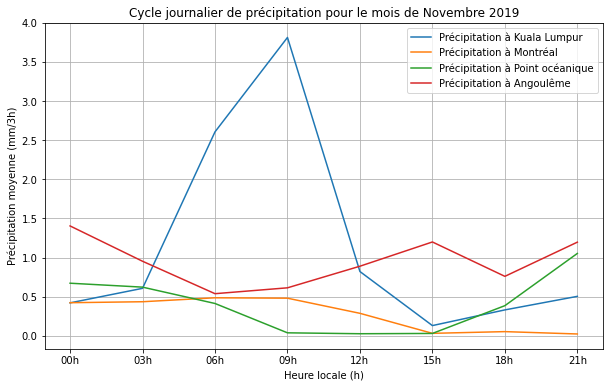

In [18]:


precipitation_data = dataset['precipitationCal']

# Extraire les informations temporelles
times = pd.to_datetime(dataset['time'][:], origin='unix', unit='s')  # Convertir à partir de secondes depuis 1970
heures_utc = times.hour  # Extraire les heures UTC

# Fonction pour grouper par tranches de 3 heures
def grouper_par_tranches_3h(temps_utc):
    return (temps_utc // 3) * 3  # Ramène les heures à 0, 3, 6, 9, etc.

# Créer une figure pour le cycle journalier de précipitation
fig, ax = plt.subplots(figsize=(10, 6))

# Longitudes et décalages horaires
locations = {
    'Kuala Lumpur': (6.77, grid_points['Kuala Lumpur']),
    'Montréal': (-4.90, grid_points['Montréal']),
    'Point océanique': (7.07, grid_points['Point océanique']),
    'Angoulême': (0.01, grid_points['Lieu au choix'])
}

# Initialiser un dictionnaire pour stocker les données moyennées
cycle_journalier = {}

# Calculer la précipitation moyenne pour chaque tranche de 3 heures
for location, (decalage, grid) in locations.items():
    # Extraire les indices de latitude et de longitude
    lat_idx, lon_idx = grid['lat_idx'], grid['lon_idx']
    
    # Extraire les précipitations pour cet emplacement
    precipitation = precipitation_data[:, lat_idx, lon_idx].filled(np.nan)  # Remplacer les valeurs manquantes par NaN
    
    # Grouper les heures UTC par tranche de 3 heures
    heures_tranches = grouper_par_tranches_3h(heures_utc)
    
    # Calculer la moyenne des précipitations pour chaque tranche de 3 heures
    precip_moyenne_par_tranche = np.array([np.nanmean(precipitation[heures_tranches == h]) for h in range(0, 24, 3)])
    
    # Tracer la courbe de précipitation moyenne pour cet emplacement
    ax.plot(range(0, 24, 3), precip_moyenne_par_tranche, label=f'Précipitation à {location}')

# Configurer les étiquettes de l'axe des x
ax.set_xticks(range(0, 24, 3))
ax.set_xticklabels(['00h', '03h', '06h', '09h', '12h', '15h', '18h', '21h'])

# Configurer les autres éléments du graphique
ax.set_xlabel('Heure locale (h)')
ax.set_ylabel('Précipitation moyenne (mm/3h)')
ax.set_title('Cycle journalier de précipitation pour le mois de Novembre 2019')
ax.legend()
ax.grid(True)

# Sauvegarder l'image
#plt.savefig('C:/Users/thoma/OneDrive/Images/Saved Pictures/cycle_journalier_precipitation.png', bbox_inches='tight', dpi=300)

# Afficher le graphique
plt.show()


Données extraites avec succès pour le 1er novembre 2019 à 12h UTC


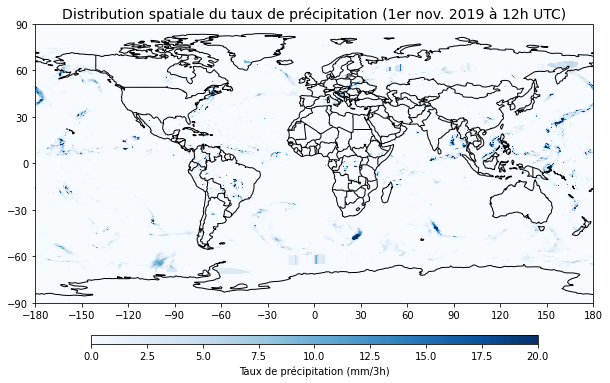

In [36]:


if 'precipitationCal' in dataset.variables:
    precip_data = dataset.variables['precipitationCal']
    
    try:
        precip_1nov_12utc = precip_data[40, :, :]  # L'index 40 correspond à 12h UTC pour cette date spécifique
        print("Données extraites avec succès pour le 1er novembre 2019 à 12h UTC")
    except RuntimeError as e:
        print(f"Erreur lors de la lecture des données : {e}")
else:
    print("La variable 'precipitationCal' n'est pas disponible dans le dataset.")

# Si l'extraction des données est réussie, poursuivre avec le tracé
try:
    # Limiter les valeurs des précipitations pour l'affichage
    precip_1nov_12utc = np.where(precip_1nov_12utc > 20, 20, precip_1nov_12utc)

    # Configurer la figure et les axes
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Tracer la carte avec la projection Lambert Cylindrical
    mesh = ax.pcolormesh(dataset.variables['lon'][:], dataset.variables['lat'][:], precip_1nov_12utc, 
                         cmap='Blues', vmin=0, vmax=20, transform=ccrs.PlateCarree())

    # Ajouter les côtes et les frontières des pays
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)

    # Ajouter les étiquettes de latitude et longitude
    ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.xformatter = ccrs.Geodetic()
    ax.yformatter = ccrs.Geodetic()

    # Personnaliser la barre des couleurs
    cbar = plt.colorbar(mesh, orientation='horizontal', fraction=0.03, pad=0.1, aspect=50, shrink=0.8)
    cbar.set_label('Taux de précipitation (mm/3h)')

    # Ajouter un titre à la carte
    ax.set_title("Distribution spatiale du taux de précipitation (1er nov. 2019 à 12h UTC)", fontsize=14)

    # Sauvegarder la figure dans un fichier PNG
   # save_path = r'C:/Users/thoma/OneDrive/Images/Saved Pictures/distribution_precipitation_1nov_2019.png'
   # plt.savefig(save_path, bbox_inches='tight', dpi=300)

    # Afficher la figure
    plt.show()

except Exception as e:
    print(f"Erreur lors de l'affichage ou de la sauvegarde de la figure : {e}")


Données extraites avec succès pour le 1er novembre 2019 à 12h UTC


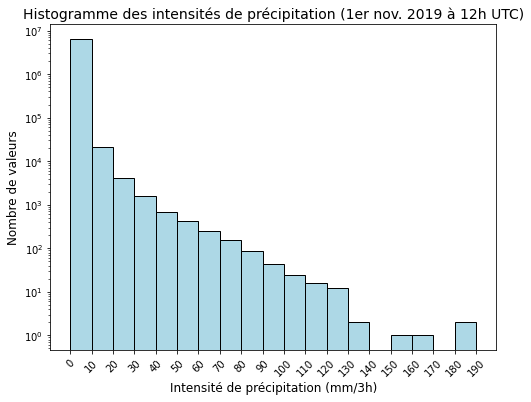

In [39]:


if 'precipitationCal' in dataset.variables:
    precip_data = dataset.variables['precipitationCal']
    
    try:
        precip_1nov_12utc = precip_data[40, :, :]  # L'index 40 correspond à 12h UTC pour cette date spécifique
        print("Données extraites avec succès pour le 1er novembre 2019 à 12h UTC")
    except RuntimeError as e:
        print(f"Erreur lors de la lecture des données : {e}")
else:
    print("La variable 'precipitationCal' n'est pas disponible dans le dataset.")

try:
    # Remplacer les valeurs manquantes par NaN et aplatir les données en un tableau 1D
    precip_1nov_12utc_clean = np.where(precip_1nov_12utc == -9999.9, np.nan, precip_1nov_12utc).flatten()
    
    # Supprimer les valeurs NaN
    precip_1nov_12utc_clean = precip_1nov_12utc_clean[~np.isnan(precip_1nov_12utc_clean)]

    # Définir les classes d'intensité avec des intervalles de 10 mm
    bins = np.arange(0, np.nanmax(precip_1nov_12utc_clean) + 10, 10)
    
    # Tracer l'histogramme avec des classes d'intensité
    plt.figure(figsize=(8, 6))
    plt.hist(precip_1nov_12utc_clean, bins=bins, log=True, color='lightblue', edgecolor='black')

    # Configurer les graduations de l'axe des abscisses tous les 10 mm
    plt.xticks(np.arange(0, np.nanmax(precip_1nov_12utc_clean) + 10, 10), rotation=45)

    # Configurer le graphique
    plt.title("Histogramme des intensités de précipitation (1er nov. 2019 à 12h UTC)", fontsize=14)
    plt.xlabel("Intensité de précipitation (mm/3h)", fontsize=12)
    plt.ylabel("Nombre de valeurs", fontsize=12)
    
    #save_path_histogram = r'C:/Users/thoma/OneDrive/Images/Saved Pictures/histogramme_precipitation_1nov_2019_10mm.png'
    #plt.savefig(save_path_histogram, bbox_inches='tight', dpi=300)

    # Afficher le graphique
    plt.show()

except Exception as e:
    print(f"Erreur lors du tracé de l'histogramme : {e}")


Données extraites avec succès pour le 1er novembre 2019 à 12h UTC


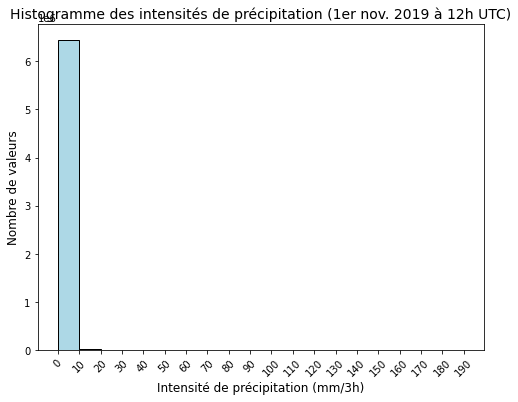

In [40]:


# Vérifier si les données de 'precipitationCal' sont disponibles
if 'precipitationCal' in dataset.variables:
    precip_data = dataset.variables['precipitationCal']
    
    # Essayer de lire une seule tranche de temps pour diagnostiquer
    try:
        precip_1nov_12utc = precip_data[40, :, :]  # L'index 40 correspond à 12h UTC pour cette date spécifique
        print("Données extraites avec succès pour le 1er novembre 2019 à 12h UTC")
    except RuntimeError as e:
        print(f"Erreur lors de la lecture des données : {e}")
else:
    print("La variable 'precipitationCal' n'est pas disponible dans le dataset.")

# Étape 3 : Nettoyer les données et préparer l'histogramme
try:
    # Remplacer les valeurs manquantes par NaN et aplatir les données en un tableau 1D
    precip_1nov_12utc_clean = np.where(precip_1nov_12utc == -9999.9, np.nan, precip_1nov_12utc).flatten()
    
    # Supprimer les valeurs NaN
    precip_1nov_12utc_clean = precip_1nov_12utc_clean[~np.isnan(precip_1nov_12utc_clean)]

    # Définir les classes d'intensité avec des intervalles de 10 mm
    bins = np.arange(0, np.nanmax(precip_1nov_12utc_clean) + 10, 10)
    
    # Tracer l'histogramme avec des classes d'intensité (sans échelle logarithmique)
    plt.figure(figsize=(8, 6))
    plt.hist(precip_1nov_12utc_clean, bins=bins, color='lightblue', edgecolor='black')

    # Configurer les graduations de l'axe des abscisses tous les 10 mm
    plt.xticks(np.arange(0, np.nanmax(precip_1nov_12utc_clean) + 10, 10), rotation=45)

    # Configurer le graphique
    plt.title("Histogramme des intensités de précipitation (1er nov. 2019 à 12h UTC)", fontsize=14)
    plt.xlabel("Intensité de précipitation (mm/3h)", fontsize=12)
    plt.ylabel("Nombre de valeurs", fontsize=12)
    
    #save_path_histogram = r'C:/Users/thoma/OneDrive/Images/Saved Pictures/histogramme_precipitation_1nov_2019_non_log.png'
    #plt.savefig(save_path_histogram, bbox_inches='tight', dpi=300)

    # Afficher le graphique
    plt.show()

except Exception as e:
    print(f"Erreur lors du tracé de l'histogramme : {e}")


Précipitations moyennes calculées avec succès sur 240 pas de temps.


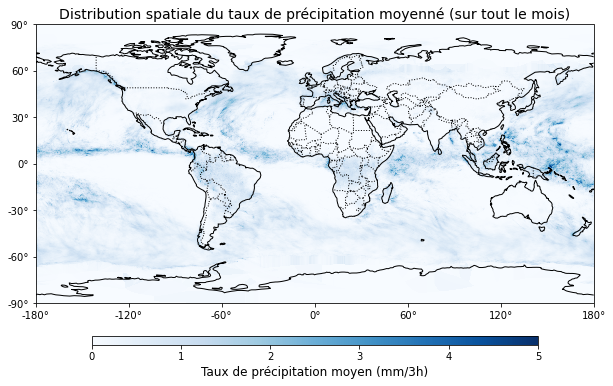

In [46]:


# Vérifier si les données de 'precipitationCal' sont disponibles
if 'precipitationCal' in dataset.variables:
    precip_data = dataset.variables['precipitationCal']
    
    # Initialiser une matrice pour la somme des précipitations
    precip_sum = np.zeros((precip_data.shape[1], precip_data.shape[2]), dtype=np.float32)
    
    # Initialiser un compteur pour les pas de temps valides
    valid_time_steps = 0
    
    try:
        # Parcourir les données temporelles par petits lots pour économiser de la mémoire
        for t in range(precip_data.shape[0]):  # Boucle sur toutes les tranches de temps
            precip_t = precip_data[t, :, :]  # Charger les données pour un seul pas de temps
            precip_t = np.where(precip_t == -9999.9, np.nan, precip_t)  # Gérer les valeurs manquantes
            
            # Ajouter les précipitations à la somme si elles sont valides
            if np.any(~np.isnan(precip_t)):
                precip_sum += np.nan_to_num(precip_t)  # Ajouter en gérant les NaN
                valid_time_steps += 1  # Incrémenter le compteur de pas de temps valides

        # Calculer la moyenne mensuelle
        precip_monthly_mean = precip_sum / valid_time_steps
        print(f"Précipitations moyennes calculées avec succès sur {valid_time_steps} pas de temps.")
        
    except RuntimeError as e:
        print(f"Erreur lors du calcul des moyennes mensuelles : {e}")
else:
    print("La variable 'precipitationCal' n'est pas disponible dans le dataset.")

# Étape 2 : Tracer la distribution spatiale
try:
    plt.figure(figsize=(10, 6))

    # Définir la projection
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Tracer la carte de précipitation moyennée sur tout le mois avec pcolormesh
    pcm = ax.pcolormesh(longitudes, latitudes, precip_monthly_mean, cmap='Blues', vmin=0, vmax=5, transform=ccrs.PlateCarree())

    # Ajouter les côtes, les frontières, et autres éléments géographiques
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    
    # Ajouter les ticks des latitudes et longitudes
    ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{int(val)}°'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{int(val)}°'))

    # Ajouter la barre des couleurs plus fine
    cbar = plt.colorbar(pcm, orientation='horizontal', fraction=0.03, pad=0.1, aspect=50, shrink=0.8)  # Aspect réduit pour une barre plus fine
    cbar.set_label('Taux de précipitation moyen (mm/3h)', fontsize=12)

    # Configurer le titre
    plt.title("Distribution spatiale du taux de précipitation moyenné (sur tout le mois)", fontsize=14)

    # Sauvegarder la figure
    #save_path_map = r'C:/Users/thoma/OneDrive/Images/Saved Pictures/distribution_spatiale_moyenne_mois_ticks.png'
    #plt.savefig(save_path_map, bbox_inches='tight', dpi=300)

    # Afficher le graphique
    plt.show()

except Exception as e:
    print(f"Erreur lors du tracé de la distribution spatiale : {e}")


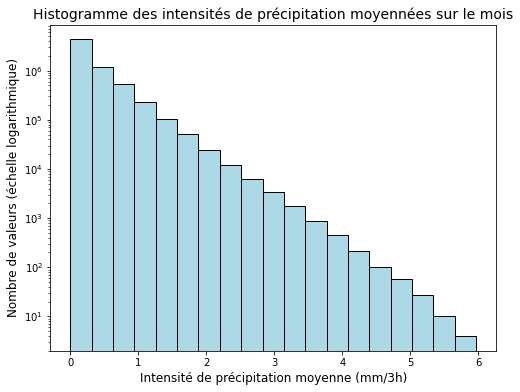

In [47]:


# Vérifier si les précipitations moyennes sur le mois sont bien calculées
if 'precip_monthly_mean' in locals():
    # Créer l'histogramme
    plt.figure(figsize=(8, 6))
    
    # Définir les limites des précipitations pour les classes d'intensité
    bins = np.linspace(0, np.nanmax(precip_monthly_mean), 20)

    # Créer l'histogramme avec une échelle logarithmique sur l'axe y
    plt.hist(precip_monthly_mean.flatten(), bins=bins, color='lightblue', edgecolor='black')
    
    # Configurer l'échelle logarithmique sur l'axe y
    plt.yscale('log')

    # Ajouter des étiquettes et un titre
    plt.xlabel("Intensité de précipitation moyenne (mm/3h)", fontsize=12)
    plt.ylabel("Nombre de valeurs (échelle logarithmique)", fontsize=12)
    plt.title("Histogramme des intensités de précipitation moyennées sur le mois", fontsize=14)

    # Sauvegarder la figure
    #save_path_hist = r'C:/Users/thoma/OneDrive/Images/Saved Pictures/histogramme_precip_moyenne_mois_log.png'
    #plt.savefig(save_path_hist, bbox_inches='tight', dpi=300)

    # Afficher l'histogramme
    plt.show()
else:
    print("Erreur: Les précipitations moyennes pour le mois ne sont pas disponibles.")


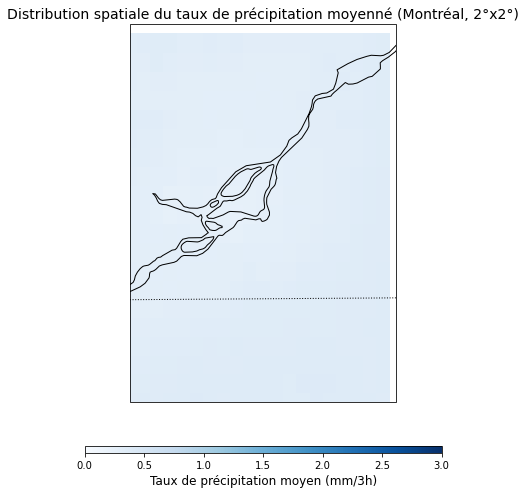

In [53]:


# Paramètres de précipitation
cmap = 'Blues'
vmin = 0  # Valeur minimale de précipitation
vmax = 3  # Valeur maximale réduite pour une échelle plus fine

# Création de la carte avec la projection Mercator
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Tracer la carte de précipitation moyennée
pcm = ax.pcolormesh(lon_region, lat_region, precip_region, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

# Ajouter les côtes et les frontières des pays
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

ax.set_extent([longitudes[lon_min_idx], longitudes[lon_max_idx], latitudes[lat_min_idx], latitudes[lat_max_idx]], crs=ccrs.PlateCarree())


cbar = plt.colorbar(pcm, orientation='horizontal',fraction=0.03, pad=0.1, aspect=50, shrink=0.8)
cbar.set_label('Taux de précipitation moyen (mm/3h)', fontsize=12)

plt.title("Distribution spatiale du taux de précipitation moyenné (Montréal, 2°x2°)", fontsize=14)

#save_path_map_region = r'C:/Users/thoma/OneDrive/Images/Saved Pictures/distribution_precip_montreal_2x2_corrected.png'
#plt.savefig(save_path_map_region, bbox_inches='tight', dpi=300)

plt.show()


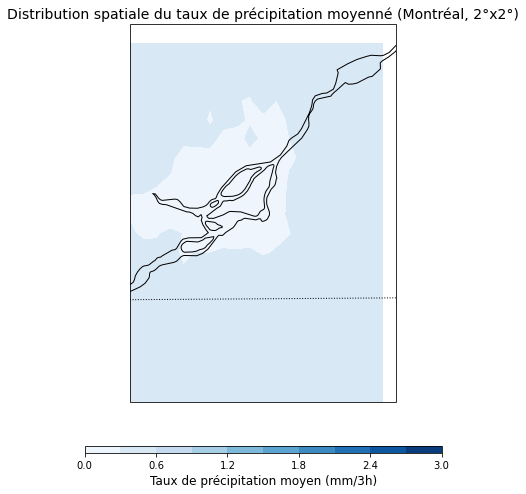

In [55]:


# Paramètres de précipitation
cmap = 'Blues'
vmin = 0  # Valeur minimale de précipitation
vmax = 3  # Valeur maximale réduite pour une échelle plus fine
levels = np.linspace(vmin, vmax, 11)  # Définir les niveaux pour contourf

# Création de la carte avec la projection Mercator
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Tracer la carte de précipitation moyennée avec contourf
contour = ax.contourf(lon_region, lat_region, precip_region, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

# Ajouter les côtes et les frontières des pays
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Définir l'étendue de la carte pour la région autour de Montréal
ax.set_extent([longitudes[lon_min_idx], longitudes[lon_max_idx], latitudes[lat_min_idx], latitudes[lat_max_idx]], crs=ccrs.PlateCarree())



# Améliorer la barre des couleurs (plus fine)
cbar = plt.colorbar(contour, orientation='horizontal', fraction=0.03, pad=0.1, aspect=50, shrink=0.8)
cbar.set_label('Taux de précipitation moyen (mm/3h)', fontsize=12)

# Ajouter un titre
plt.title("Distribution spatiale du taux de précipitation moyenné (Montréal, 2°x2°)", fontsize=14)

#save_path_map_region = r'C:/Users/thoma/OneDrive/Images/Saved Pictures/distribution_precip_montreal_2x2_contourf.png'
#plt.savefig(save_path_map_region, bbox_inches='tight', dpi=300)

# Afficher le graphique
plt.show()


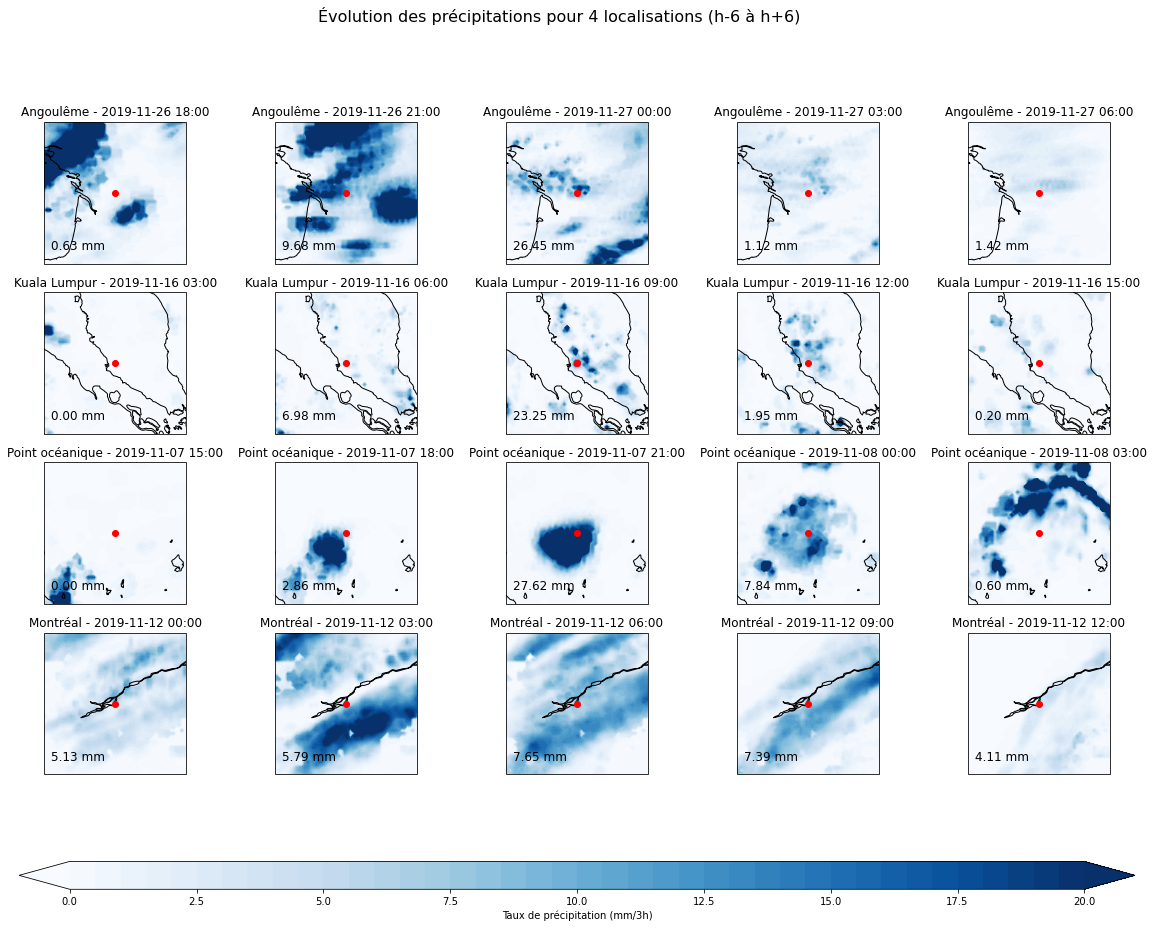

In [74]:


# Localisation des quatre endroits
locations = {
    'Angoulême': {'lat': 45.65, 'lon': 0.16},
    'Kuala Lumpur': {'lat': 3.1, 'lon': 101.6},
    'Point océanique': {'lat': 5.0, 'lon': 106.0},
    'Montréal': {'lat': 45.5, 'lon': -73.5}
}

# Trouver les indices pour chaque endroit
grid_points = {}
for location, coords in locations.items():
    lat_idx = np.argmin(np.abs(latitudes - coords['lat']))
    lon_idx = np.argmin(np.abs(longitudes - coords['lon']))
    grid_points[location] = {'lat_idx': lat_idx, 'lon_idx': lon_idx}

# Trouver les moments des précipitations maximales pour chaque endroit
max_times = {}
for location, point in grid_points.items():
    precip_loc = dataset.variables['precipitationCal'][:, point['lat_idx'], point['lon_idx']]
    max_time_idx = np.argmax(precip_loc)
    max_times[location] = max_time_idx

# Définir les niveaux de précipitation
levels = np.arange(0, 20.5, 0.5)  # De 0 à 20 mm avec un pas de 0.5 mm

# Extraire le temps de la variable 'time' du dataset et définir start_time
time_variable = dataset.variables['time'][:]
start_time = pd.to_datetime(time_variable[0], unit='s', origin='unix')

# Créer une figure avec 4 lignes et 5 colonnes pour chaque localisation
fig, axes = plt.subplots(4, 5, figsize=(20, 16), subplot_kw={'projection': ccrs.PlateCarree()})

# Tracer les graphiques pour chaque localisation et chaque instant (h-6, h-3, h, h+3, h+6)
times = [-6, -3, 0, 3, 6]
for i, (location, max_time_idx) in enumerate(max_times.items()):
    lat_idx = grid_points[location]['lat_idx']
    lon_idx = grid_points[location]['lon_idx']
    
    for j, t in enumerate(times):
        time_idx = max_time_idx + (t // 3)
        ax = axes[i, j]

        # Tracer la carte avec contourf
        cs = ax.contourf(longitudes, latitudes, precip_data[time_idx, :, :], levels=levels, cmap='Blues', extend='both')

        # Ajouter la côte et le point rouge pour chaque localisation
        ax.coastlines()
        ax.plot(locations[location]['lon'], locations[location]['lat'], 'ro')

        # Zoomer autour de la localisation
        lat_min, lat_max = locations[location]['lat'] - 2.5, locations[location]['lat'] + 2.5
        lon_min, lon_max = locations[location]['lon'] - 2.5, locations[location]['lon'] + 2.5
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        # Titre avec l'instant correspondant
        time_str = (start_time + pd.Timedelta(hours=time_idx * 3)).strftime('%Y-%m-%d %H:%M')
        ax.set_title(f"{location} - {time_str}")

        # Ajouter la valeur de précipitation dans la case
        precip_value = precip_data[time_idx, lat_idx, lon_idx]
        ax.text(0.05, 0.1, f"{precip_value:.2f} mm", transform=ax.transAxes, fontsize=12, color='black')

# Ajouter la barre des couleurs en dessous de la série de graphiques
cbar = fig.colorbar(cs, ax=axes, orientation='horizontal', pad=0.1, aspect=40)
cbar.set_label('Taux de précipitation (mm/3h)')

# Titre général
fig.suptitle("Évolution des précipitations pour 4 localisations (h-6 à h+6)", fontsize=16)

# Sauvegarder la figure si nécessaire
#plt.savefig('C:/Users/thoma/OneDrive/Images/Saved Pictures/precipitation_evolution_four_locations_zoom.png')

plt.show()
